In [1]:
from extract_data import *

# Don't use this cell unless you want fresh import (very slow)

cat_data = get_data('data/categorised.json')
uncat_data = get_data('data/uncategorised.json')
unlinked_data = get_data('data/unlinked.json')

save_list(cat_data, 'pickle_data', 'cat_data')
save_list(uncat_data, 'pickle_data', 'uncat_data')
save_list(unlinked_data, 'pickle_data', 'unlinked_data')


100%|██████████| 6071/6071 [2:10:54<00:00,  1.29s/it]


In [1]:
from extract_data import *

# Load the data from here using pickle (much faster)

cat_data = load_list('pickle_data', 'cat_data')
uncat_data = load_list('pickle_data', 'uncat_data')
unlinked_data = load_list('pickle_data', 'unlinked_data')


C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Data Format
On calling get_data (or loading the lists using pickle) it returns a list of each incident. Each incident has 4 objects.

## Data[0]
This is the 'zoomed in' data from -6 seconds to +3 seconds. This includes speed and direction.

These data are also in Data[2].

## Data[1]
This is the 8hz, high resolution tilt data from -6 seconds to +2.875 seconds.

## Data[2]
This is the 'zoomed out' data from the beginning of the recording, throught the incident to the end.

This includes events, speed, directions, grid references, tilts

unlinked_data does not contain this.

## Data[3]
This is the status of the incident, i.e. whether it is a confirmed crash of not.

unlinked_data does not contain this.

Other


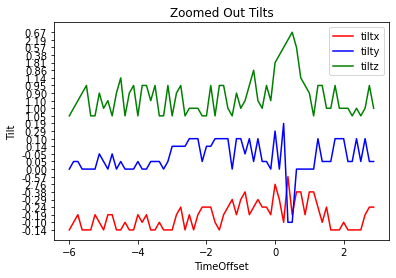

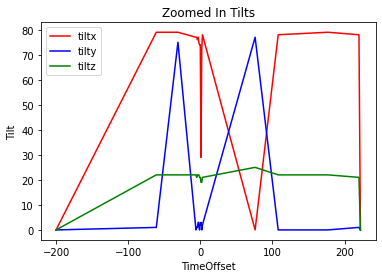

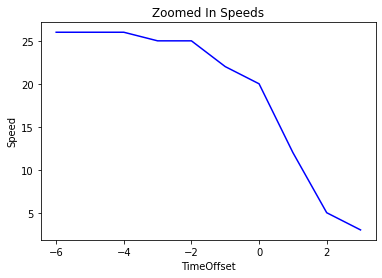

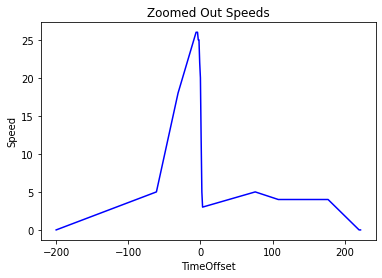

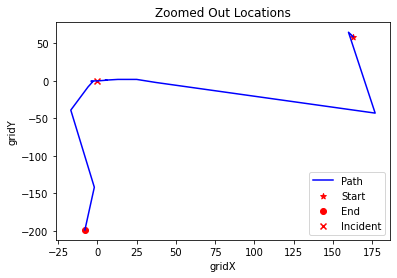

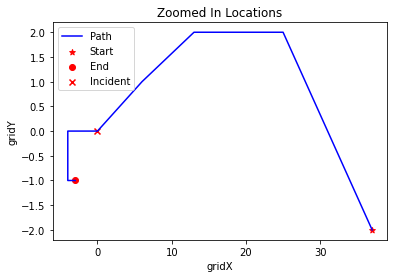

In [3]:
def plot_tilts(df, title):
    plt.plot(df['timeoffset'], df['tiltx'], label='tiltx', color='red')
    plt.plot(df['timeoffset'], df['tilty'], label='tilty', color='blue')
    plt.plot(df['timeoffset'], df['tiltz'], label='tiltz', color='green')
    plt.title(title), plt.xlabel('TimeOffset'), plt.ylabel('Tilt')
    plt.legend(loc='best')
    plt.show()

def plot_speeds(df, title):
    plt.plot(df['timeoffset'], df['speed'], label='Speed', color='blue')
    plt.title(title), plt.xlabel('TimeOffset'), plt.ylabel('Speed')
    plt.show()

def plot_grid(df, title):
    X = df['gridx']
    Y = df['gridy']
    plt.plot(X, Y, label='Path', color='blue')
    plt.scatter(X.iloc[0], Y.iloc[0], label='Start', marker='*', color='red')
    plt.scatter(X.iloc[-1], Y.iloc[-1], label='End', marker='o', color='red')
    plt.scatter(0,0, label='Incident', color='red', marker='x')
    plt.legend(loc='best')
    plt.title(title), plt.xlabel('gridX'), plt.ylabel('gridY')
    plt.show()

# accessing incident number 8
data = cat_data[14]
# in this instance data[0] is the 'zoomed in' information
print(data[3])

# Plotting
plot_tilts(data[1], 'Zoomed Out Tilts')
plot_tilts(data[2], 'Zoomed In Tilts')
plot_speeds(data[0], 'Zoomed In Speeds')
plot_speeds(data[2], 'Zoomed Out Speeds')
plot_grid(data[2], 'Zoomed Out Locations')
plot_grid(data[0], 'Zoomed In Locations')


In [ ]:
from extract_data import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, KShape
from sklearn.metrics import confusion_matrix, accuracy_score


# Using TSKMeans with multiple classes to see what goes where

X_train = get_tilt_timeseries(unlinked_data)
X_test = get_tilt_timeseries(cat_data)
y_test = get_labels(cat_data)

print(X_train.shape)
print(X_test.shape)
print(len(y_test))

X_train = get_mags(X_train)
X_test = get_mags(X_test)
print('Got mags')

for i in range(20):
    plt.plot(np.linspace(-6,2.875,72), X_train[i+1000,:])
    plt.title('Training Data - |accel|/time')
plt.show()

km = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=100)
km.fit(X_train[:,:])
y_pred = km.predict(X_test[:,:])

print(confusion_matrix(y_test, y_pred))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[4 5 3 4 2 3 4 0 0 4 0 3 4 0 3 3 4 4 0 4 3 0 5 0 4 0 3 3 4 3 0 4 4 4 0 4 4
 5 4 4 0 4 3 4 3 5 4 2 3 4 3 5 0 0 4 0 4 0 4 4 0 0 4 0 4 4 3 0 0 0 0 0 0 4
 4 4 3 4 4 4 4 4 0 3 4 4 4 4 0 0 0 5 3 4 4]
(72, 1)


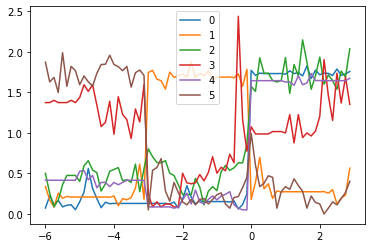

In [27]:
# Plot results from timeseriesKMeans

print(y_test)
print(y_pred)

centroids = km.cluster_centers_
print(centroids[1].shape)
centroids = np.reshape(centroids, (6,72))

timeoffset = np.linspace(-6,2.875,72)
for i in range(6):
    plt.plot(timeoffset, centroids[i,:], label=str(i))

plt.legend(loc='best')
plt.show()

100%|██████████| 95/95 [00:00<00:00, 5000.24it/s]


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
(95, 72)
[[ 2 77]
 [ 0 16]]


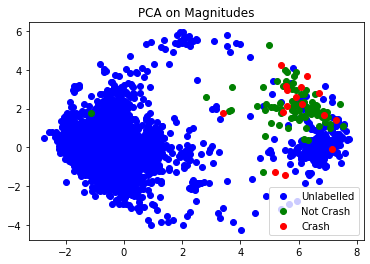

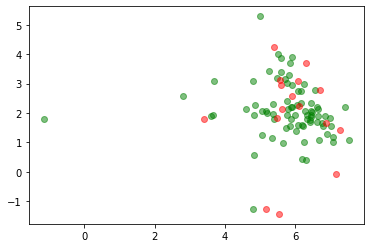

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Experimenting with PCA

X_train = get_tilt_timeseries(unlinked_data)
X_test = get_tilt_timeseries(cat_data)
y_test = np.array(get_labels(cat_data))

#X_train =get_mags(X_train)
#X_test = get_mags(X_test)
X_train = X_train[:,:,2]
X_test = X_test[:,:,2]

crash_ref = y_test.nonzero()
nocrash_ref = (y_test-1)*(-1)
nocrash_ref = nocrash_ref.nonzero()

pca=PCA(n_components=2)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

print(y_test)
print(X_test.shape)

km_normal = KMeans(n_clusters=2)
km_normal.fit(X_train_PCA)
y_pred = km_normal.predict(X_test_PCA)

centroids = km_normal.cluster_centers_

print(confusion_matrix(y_test, y_pred))


plt.scatter(X_train_PCA[:,0], X_train_PCA[:,1], color='blue', label='Unlabelled')
plt.scatter(X_test_PCA[nocrash_ref,0], X_test_PCA[nocrash_ref,1], color='green', label='Not Crash')
plt.scatter(X_test_PCA[crash_ref,0], X_test_PCA[crash_ref,1], color='red',label='Crash')
plt.legend(loc='best'), plt.title('PCA on Magnitudes')
plt.show()

plt.scatter(X_test_PCA[nocrash_ref,0], X_test_PCA[nocrash_ref,1], color='green', alpha=0.5)
plt.scatter(X_test_PCA[crash_ref,0], X_test_PCA[crash_ref,1], color='red', alpha=0.5)
plt.show()

#plt.scatter(X_test_PCA_nocrash[:,0], X_test_PCA_nocrash[:,1], color='green')
#lt.scatter(X_test_PCA_crash[:,0], X_test_PCA_crash[:,1], color='red')

#plt.scatter(centroids[0,0], centroids[0,1], color='green')
#plt.scatter(centroids[1,0], centroids[1,1], color='yellow')

In [5]:
def get_stats(X):
    # Function that gets the means and variances for the tilts of each axis for each crash
    all_means = []
    all_vars = []
    all_ranges = []
    
    for crash in X:

        crash_means = []
        crash_vars = []
        crash_ranges = []

        for axis in range(3):
            axis = crash[:,axis]
            axis = axis.astype(float)

            mean = np.mean(axis)
            var = np.var(axis)
            a_range = np.amax(axis) - np.amin(axis)

            crash_means.append(mean)
            crash_vars.append(var)
            crash_ranges.append(a_range)
            
        all_means.append(crash_means)
        all_vars.append(crash_vars)
        all_ranges.append(crash_ranges)

    all_crash_means = np.asarray(all_means)
    all_crash_vars = np.asarray(all_vars)
    all_crash_ranges = np.asarray(all_ranges)

    return all_crash_means, all_crash_vars, all_crash_ranges

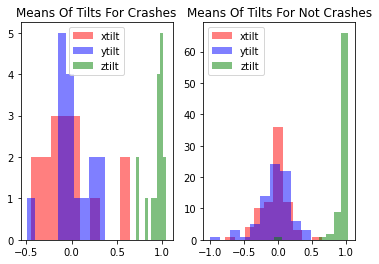

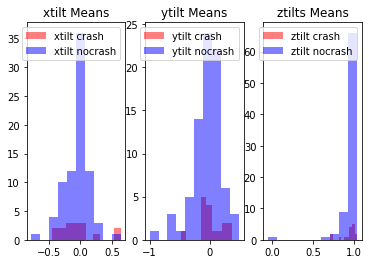

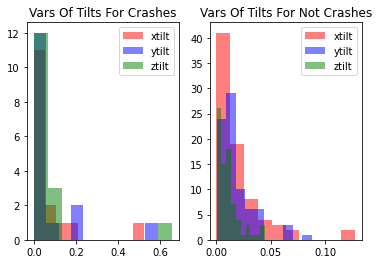

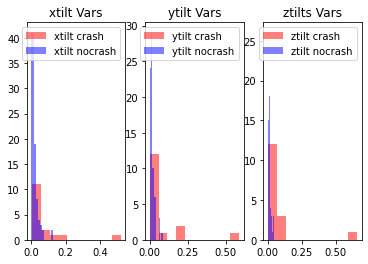

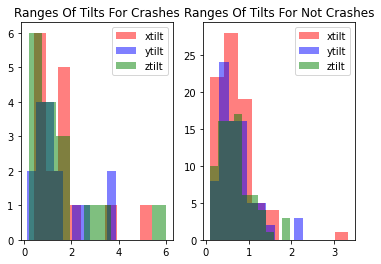

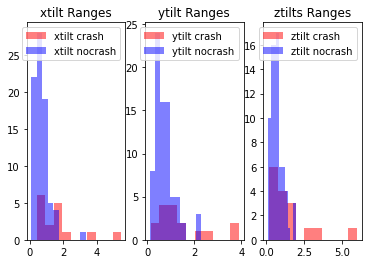

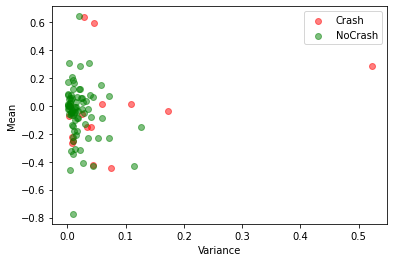

In [321]:
# Split the list up into labels and features
# These features are the 8hz tilt data
all_data = np.array(all_data)
y = all_data[:,3]
X = all_data[:,2]

all_data_uncat = np.array(all_data_uncat)
y_uncat = all_data_uncat[:,3]
X_uncat = all_data_uncat[:,2]

X_new_uncat = []
for element in range(len(X_uncat)):
    df = X_uncat[element]
    array = df.iloc[:,1:].to_numpy()
    X_new_uncat.append(array)
# X is now a list of arrays containing the 8hz tilt data
X_uncat = np.asarray(X_new_uncat)

X_new = []
for element in range(len(X)):
    df = X[element]
    array = df.iloc[:,1:].to_numpy()
    X_new.append(array)
# X is now a list of arrays containing the 8hz tilt data
X = np.asarray(X_new)

crash_ref = y.nonzero()
nocrash_ref = (y-1)*(-1)
nocrash_ref = nocrash_ref.nonzero()

X_crash = X[crash_ref]
X_nocrash = X[nocrash_ref]  

# Get the means for comparisons
crash_means, crash_vars, crash_ranges = get_stats(X_crash)
nocrash_means, nocrash_vars, nocrash_ranges = get_stats(X_nocrash)

def plot_stat_hist(stat1, stat2, stat_str):
    plt.subplot(1,2,1)
    plt.hist(stat1[:,0], color='red', label='xtilt', alpha=0.5)
    plt.hist(stat1[:,1], color='blue', label='ytilt', alpha=0.5)
    plt.hist(stat1[:,2], color='green',label='ztilt', alpha=0.5)
    plt.title(stat_str + ' Of Tilts For Crashes'), plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.hist(stat2[:,0], color='red', label='xtilt', alpha=0.5)
    plt.hist(stat2[:,1], color='blue', label='ytilt', alpha=0.5)
    plt.hist(stat2[:,2], color='green',label='ztilt', alpha=0.5)
    plt.title(stat_str + ' Of Tilts For Not Crashes'), plt.legend(loc='best')
    plt.show()

    plt.subplot(1,3,1)
    plt.hist(stat1[:,0], color='red', label='xtilt crash', alpha=0.5)
    plt.hist(stat2[:,0], color='blue', label='xtilt nocrash', alpha=0.5)
    plt.title('xtilt ' + stat_str ), plt.legend(loc='best')
    plt.subplot(1,3,2)
    plt.hist(stat1[:,1], color='red', label='ytilt crash', alpha=0.5)
    plt.hist(stat2[:,1], color='blue', label='ytilt nocrash', alpha=0.5)
    plt.title('ytilt ' + stat_str ), plt.legend(loc='best')
    plt.subplot(1,3,3)
    plt.hist(stat1[:,2], color='red', label='ztilt crash', alpha=0.5)
    plt.hist(stat2[:,2], color='blue', label='ztilt nocrash', alpha=0.5)
    plt.title('ztilts ' + stat_str ), plt.legend(loc='best')
    plt.show()

plot_stat_hist(crash_means, nocrash_means, 'Means')
plot_stat_hist(crash_vars, nocrash_vars, 'Vars')
plot_stat_hist(crash_ranges, nocrash_ranges, 'Ranges')

plt.scatter(crash_vars[:,0], crash_means[:,0], color='red', alpha=0.5, label='Crash')
plt.scatter(nocrash_vars[:,0], nocrash_means[:,0], color='green', alpha=0.5, label='NoCrash')
plt.legend(loc='best'), plt.xlabel('Variance'), plt.ylabel('Mean')
plt.show()


C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 95 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[[73  6]
 [13  3]]
Accuracy on test set: 80.0


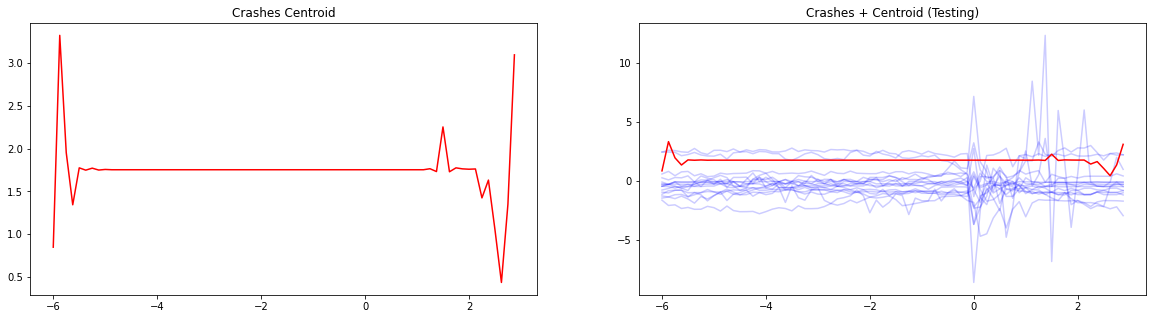

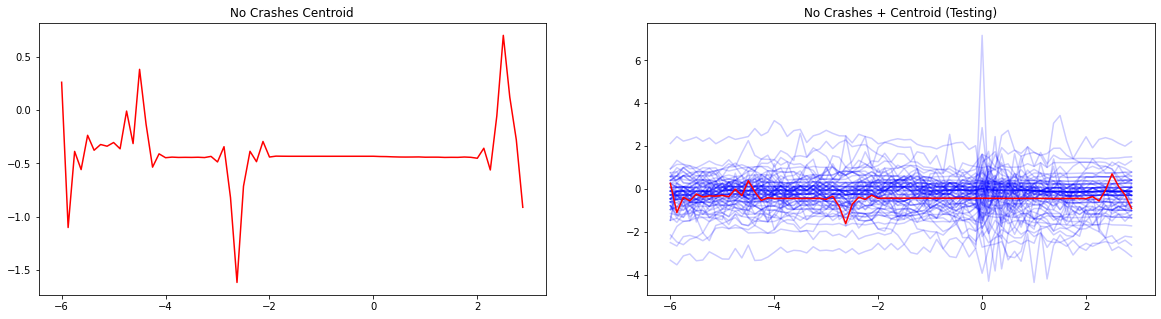

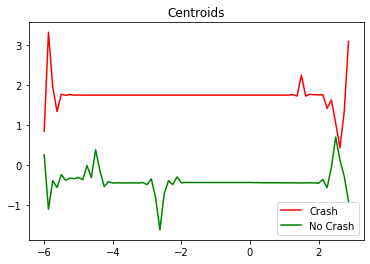

In [350]:
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, KShape
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from math import sqrt

# Time series clustering
# Get x tilts as first test of clustering

def prep_for_cluster(X, axis_number, norm=False, stan=False):

    X_xtilts=np.empty([72,len(X)])
    for i in range(len(X)):
        X_xtilts[:,i] = X[i][:,axis_number]

    X_xtilts_uncat=np.empty([72,len(X_uncat)])
    for i in range(len(X_uncat)):
        X_xtilts_uncat[:,i] = X_uncat[i][:,axis_number]

    X_xtilts = np.transpose(X_xtilts)
    X_xtilts_uncat = np.transpose(X_xtilts_uncat)

    # normalise the data
    if norm==True:
        for i in range(len(X_xtilts)):
            X_xtilts[i] = (X_xtilts[i]-X_xtilts[i].min())/(X_xtilts[i].max()-X_xtilts[i].min())
        for i in range(len(X_xtilts_uncat)):
            X_xtilts_uncat[i] = (X_xtilts_uncat[i]-X_xtilts_uncat[i].min())/(X_xtilts_uncat[i].max()-X_xtilts_uncat[i].min())

    X_train = X_xtilts_uncat
    X_test = X_xtilts

    if stan==True:
        # standardise the data
        scaler = StandardScaler()
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    return X_train, X_test

y_test = y
X_train, X_test = prep_for_cluster(X, 0, stan=True)

# Compute clusters
km = TimeSeriesKMeans(n_clusters=2, max_iter=10, metric="dtw", random_state=0).fit(X_train)
#km = KernelKMeans(n_clusters=2, max_iter=100).fit(X_train)
#km = KShape(n_clusters=2, max_iter=10).fit(X_train)

# Make predictions
test_predictions = km.predict(X_test)

# Print accuracies and confusion matrices
print(confusion_matrix(y_test.astype(int), test_predictions))
test_acc = accuracy_score(y_test.astype(int), test_predictions)
print('Accuracy on test set: '+ str(test_acc*100))

X_test_crash = X_test[y_test.nonzero()]
X_test_nocrash = X_test[((y_test-1)*-1).nonzero()]

centroids = km.cluster_centers_
linspace_1 = np.linspace(-6, 2.875, 72)

# Crash data
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(linspace_1, centroids[1], color='red', label='Crash')
plt.title('Crashes Centroid')
plt.subplot(1,2,2)
for i in range(len(X_test_crash)):
    plt.plot(linspace_1, X_test_crash[i], color='blue', alpha=0.2)
plt.plot(linspace_1, centroids[1], color='red', label='Crash')
plt.title('Crashes + Centroid (Testing)')
plt.show()

# No crash data
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(linspace_1, centroids[0], color='red', label='No Crash')
plt.title('No Crashes Centroid')
plt.subplot(1,2,2)
for i in range(len(X_test_nocrash)):
    plt.plot(linspace_1, X_test_nocrash[i], color='blue', alpha=0.2)
plt.plot(linspace_1, centroids[0], color='red', label='Crash')
plt.title('No Crashes + Centroid (Testing)')
plt.show()

#Centroid Comparison
plt.plot(linspace_1, centroids[1], color='red', label='Crash')
plt.plot(linspace_1, centroids[0], color='green', label='No Crash')
plt.legend(loc='best'), plt.title('Centroids')
plt.show()

#[TN, FP]
#[FN, TP]

## Improve accuracy:
Run k-means on each axis and combine results

Remove data from before -2 seconds to focus more on the crash (maybe even -1)

Feature extraction

(maybe try changing the test set to have even number of crashes to better see performance)

Make all the accelerometer data positive to stop opposite signed peaks cancelling in Kmeans

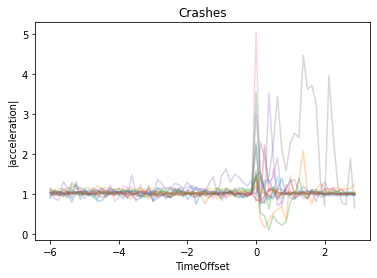

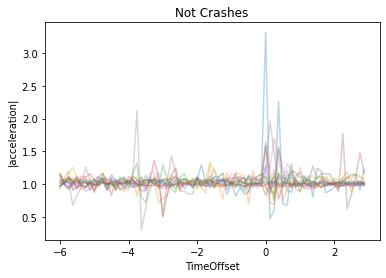

[[62 17]
 [ 8  8]]
Accuracy on test set: 73.68421052631578


C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 95 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [392]:
def get_mags(X):
    mag_X = np.empty((len(X), 72))
    for i in range(len(X)):
        for k in range(72):
            vector = np.array(X[i,k,:])
            vector = [float(i) for i in vector]
            mag = np.linalg.norm(vector[:])
            #if mag < 0:
            #   mag*-1
            mag_X[i,k] = mag
    return mag_X

mag_X_crash = get_mags(X_crash)
mag_X_nocrash = get_mags(X_nocrash)

for i in range(len(mag_X_crash)):
    plt.plot(linspace_1, mag_X_crash[i,:], alpha=0.3)
plt.title('Crashes'), plt.xlabel('TimeOffset'), plt.ylabel('|acceleration|')
plt.show()

for i in range(16):
    plt.plot(linspace_1, mag_X_nocrash[i,:], alpha=0.3)
plt.title('Not Crashes'), plt.xlabel('TimeOffset'), plt.ylabel('|acceleration|')
plt.show()

X_train = get_mags(X_uncat)
X_test = get_mags(X)

y_test = y

km = TimeSeriesKMeans(n_clusters=2, max_iter=10, metric="euclidean", random_state=0).fit(X_train)
#km = KernelKMeans(n_clusters=2, max_iter=10).fit(X_train)
#km = KShape(n_clusters=2, max_iter=10).fit(X_train)

# Make predictions
test_predictions = km.predict(X_test)

# Print accuracies and confusion matrices
print(confusion_matrix(y_test.astype(int), test_predictions))
test_acc = accuracy_score(y_test.astype(int), test_predictions)
print('Accuracy on test set: '+ str(test_acc*100))
